---
title: "🗓️ Week 07: Introduction and Dimensionality Reduction"
subtitle: "Theme: Unsupervised Learning"
author: "Dr. Ghita Berrada"
format: 
  html:
    from: markdown+emoji
    page-layout: full
    toc: true
    toc-depth: 2
self-contained: true
jupyter: python3
engine: jupyter
---

Welcome to Week 07! This week, we leave supervised learning behind (sort of 😸) and start exploring the (brave new) world of unsupervised learning... So, let's get started!

# ⚙️ Setup

Before you can load the libraries below, you might have to do the following package installs (feel free to skip if you already have done the installs before)

``` zsh
conda install xgboost lightgbm catboost #make sure to have your version of scikit-learn as 1.4.2 to avoid problems with executing XGBoost, LightGBM and CatBoost models later on
conda install -c conda-forge imbalanced-learn
pip install -U umap-learn
```

Then, let's load the libraries we'll need today.

In [1]:
# libraries for dataframe and data manipulation
import pandas as pd
import numpy as np
# libraries for plotting
from lets_plot import *
LetsPlot.setup_html()
from lets_plot.plot import gggrid
#libraries for table formatting
from pytablewriter import MarkdownTableWriter
# libraries for data exploration (e.g missing values)
import missingno as msno
import sweetviz as sv
#libraries for pre-processing the data (e.g oversampling)
from imblearn.over_sampling import SMOTE
#libraries for models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
#libraries for train/test split
from sklearn.model_selection import TimeSeriesSplit, train_test_split
#libraries for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
# libraries for metric definition (model evaluation)
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, average_precision_score,make_scorer, classification_report 
#libraries needed for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
import umap

## Part 1: Supervised learning: going a bit further

For this part, we'll look at data about financial crises (specifically Banking, Debt, Financial, Inflation and Systemic Crises) between 1860 to 2014 in 13 African countries, including: Algeria, Angola, Central African Republic, Ivory Coast, Egypt, Kenya, Mauritius, Morocco, Nigeria, South Africa, Tunisia, Zambia and Zimbabwe. The data has been made available on [Kaggle](https://www.kaggle.com/code/varunsaikanuri/financial-crisis-analysis-and-prediction/input?select=african_crises.csv). This is a simplified version of Reinhart et. al's more extensive Global Financial Stability dataset which can be found [here](https://www.hbs.edu/behavioral-finance-and-financial-stability/data/Pages/global.aspx).

Let's load our data:

In [2]:
df=pd.read_csv("../data/african_crises.csv")

Let's have an overview of our data:

                                             |          | [  0%]   00:00 -> (? left)


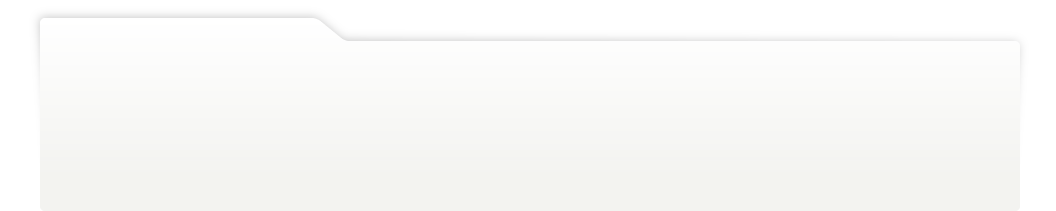
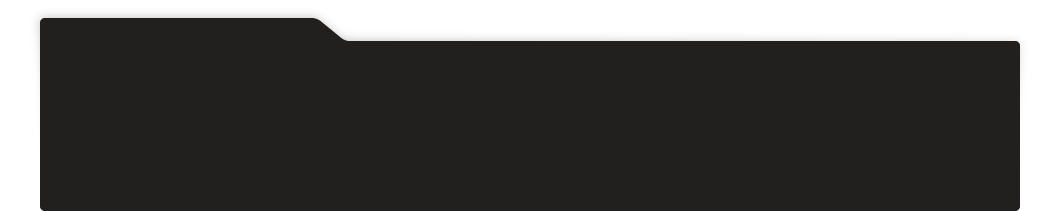
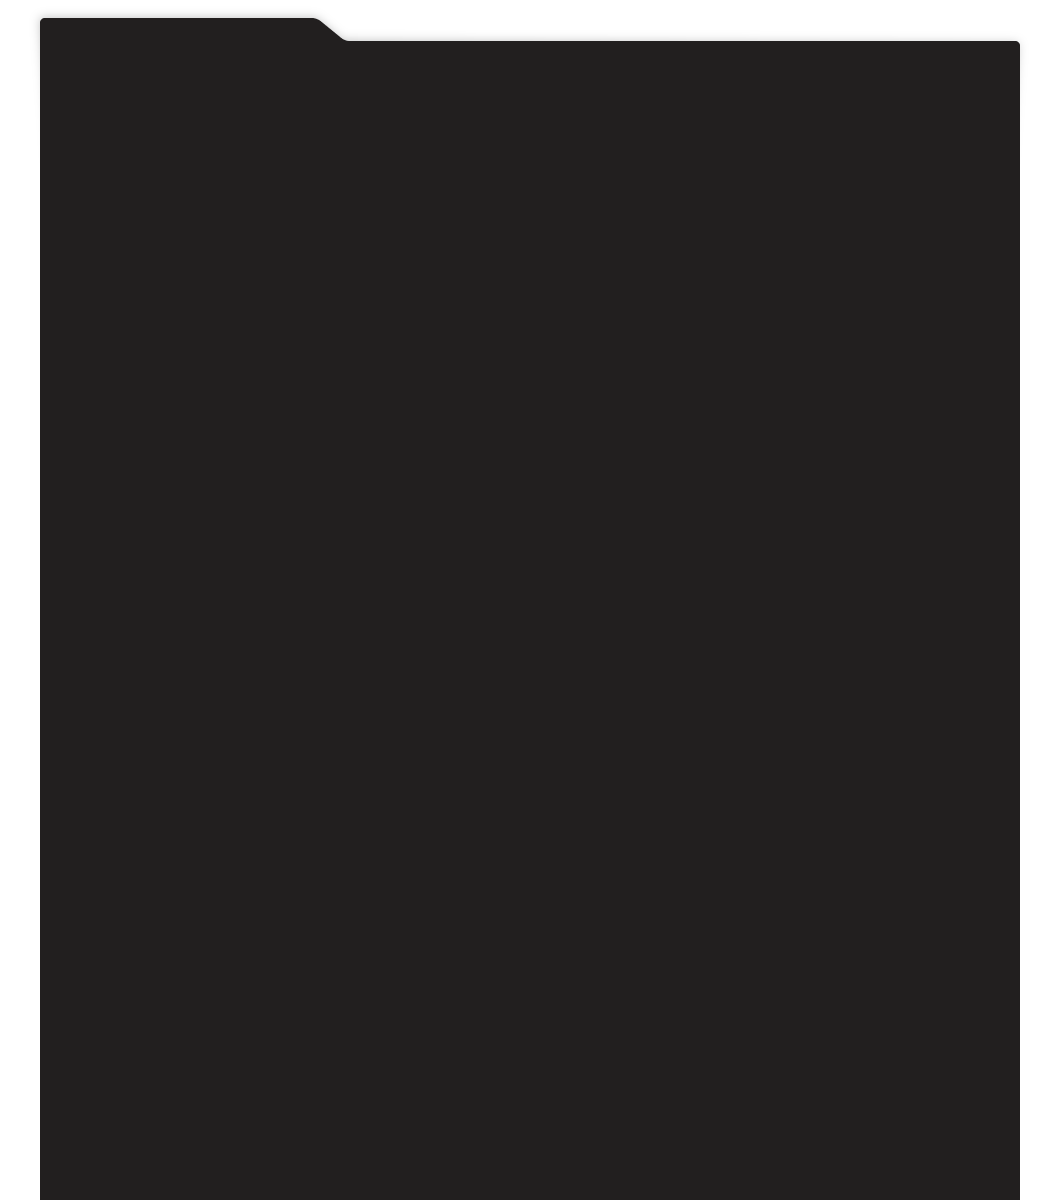
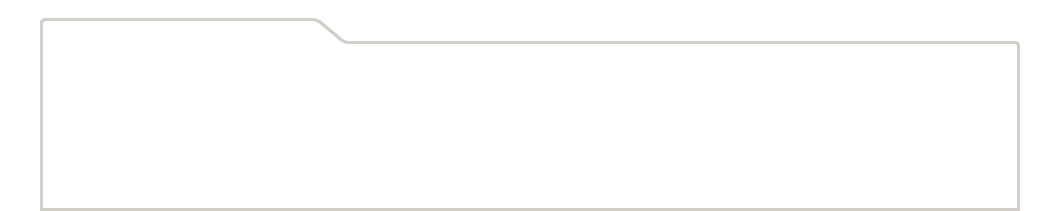
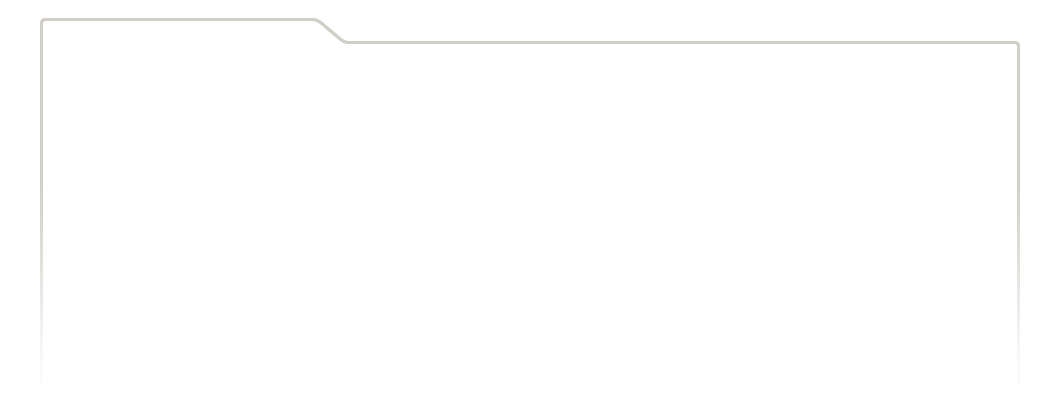
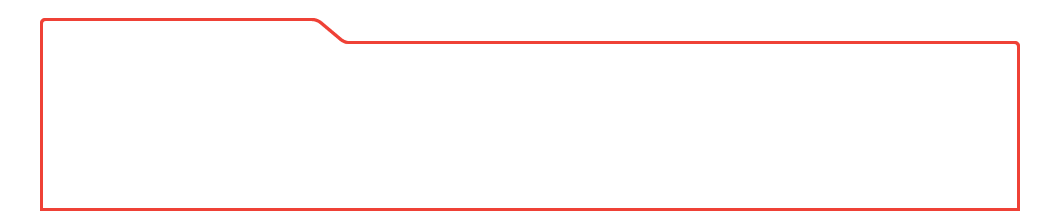
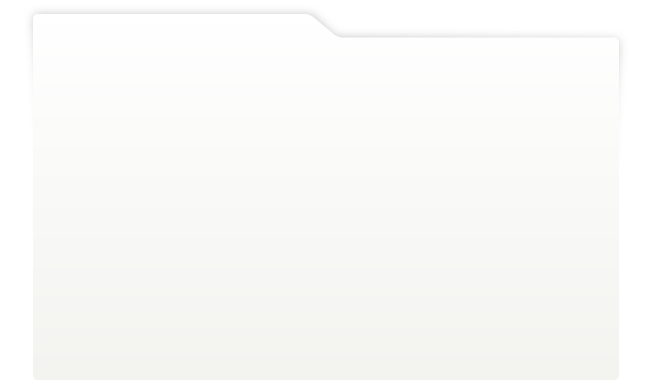
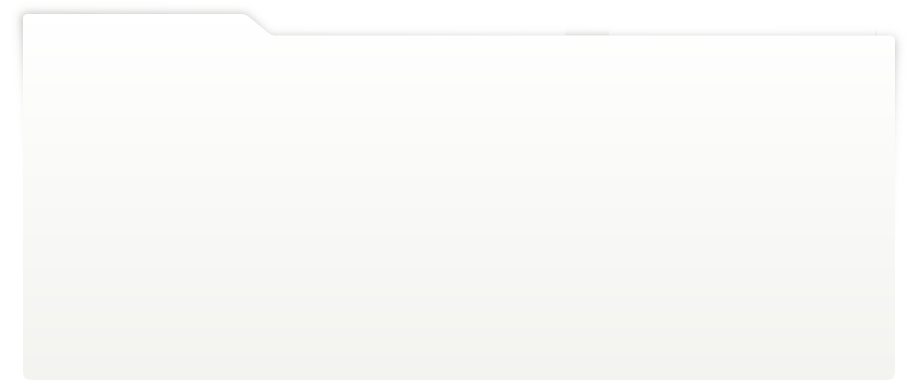
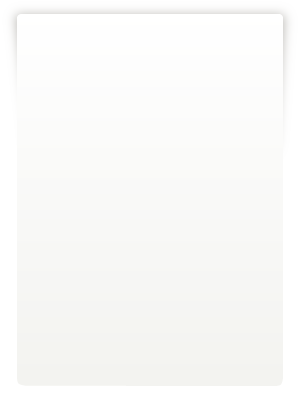
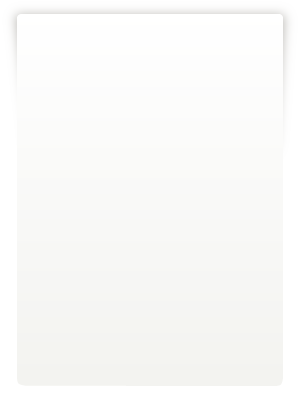
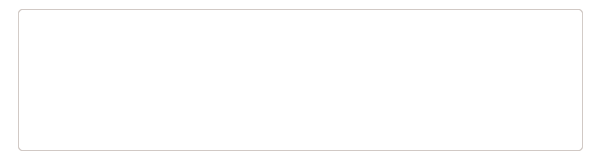
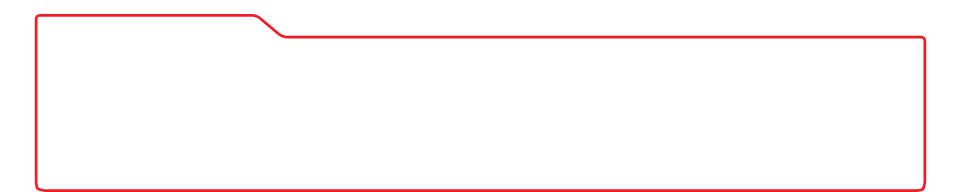
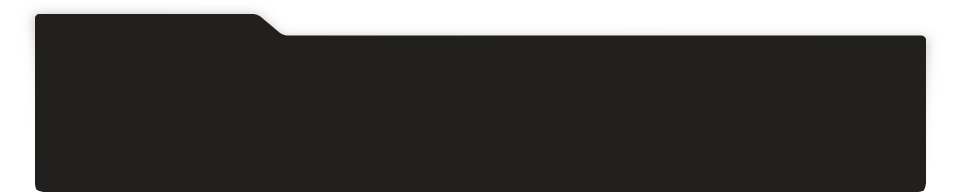
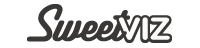
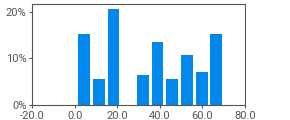
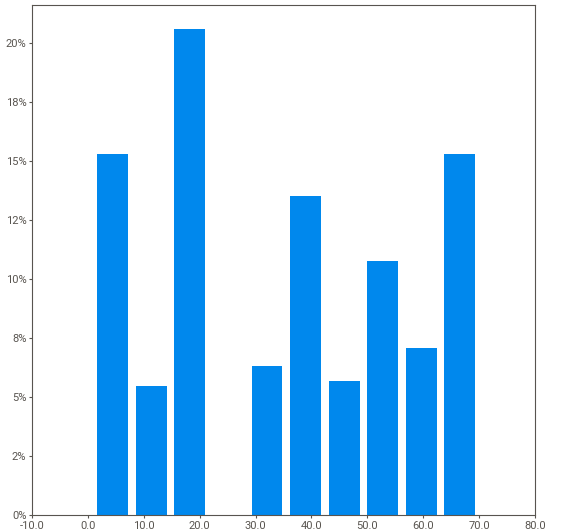
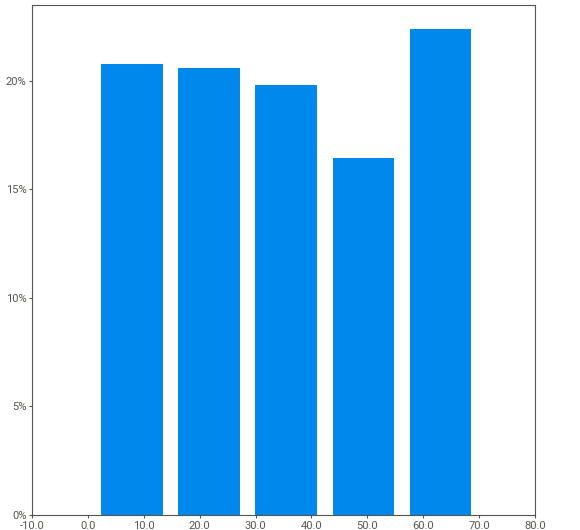
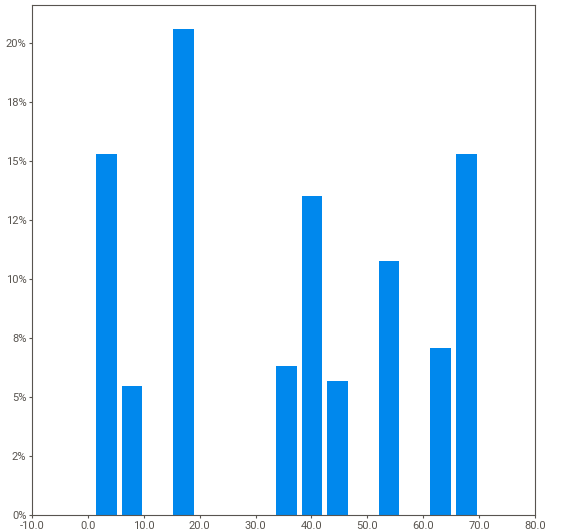
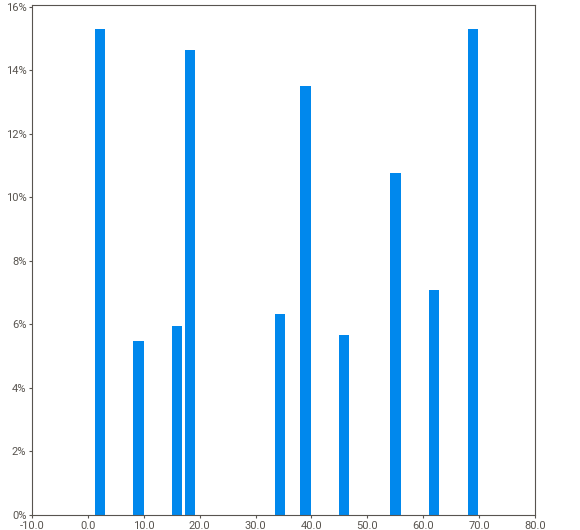
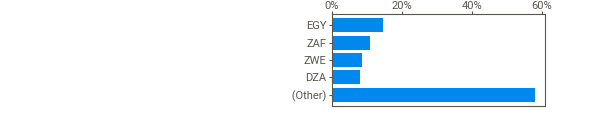
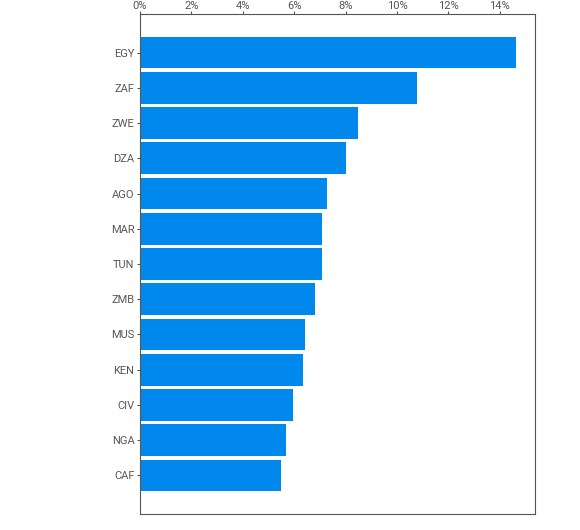
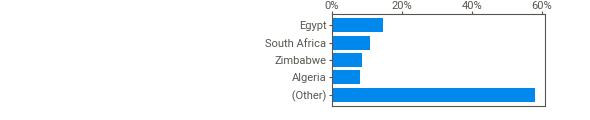
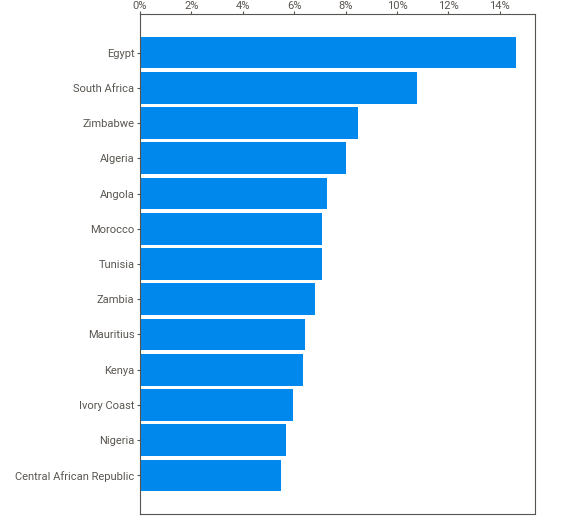
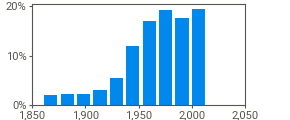
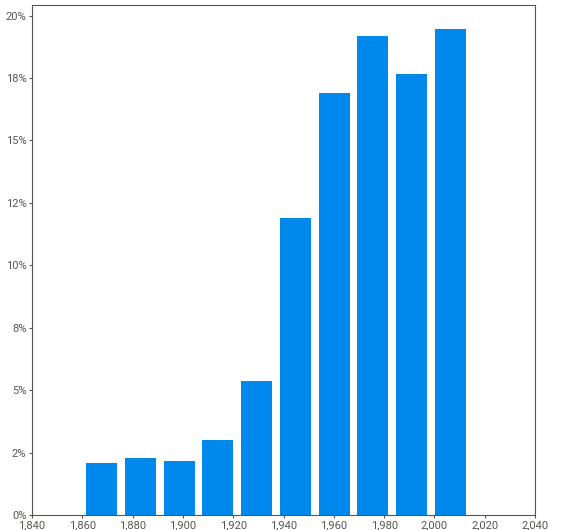
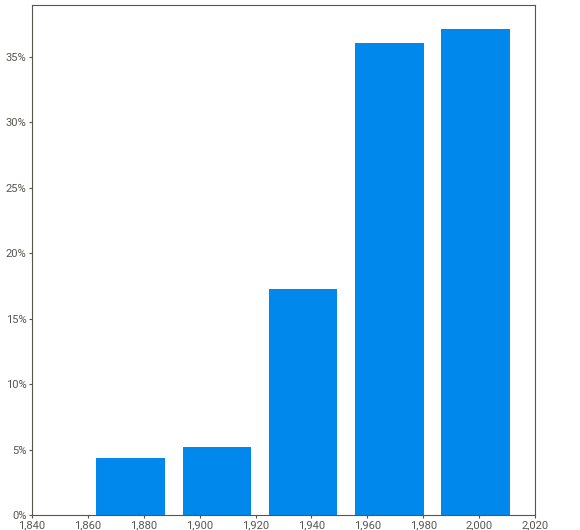
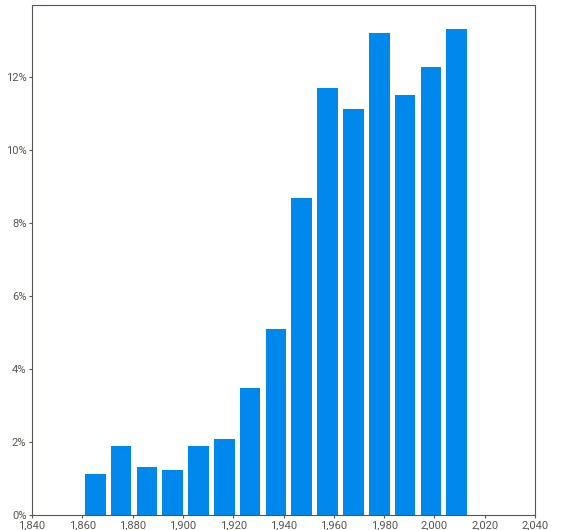
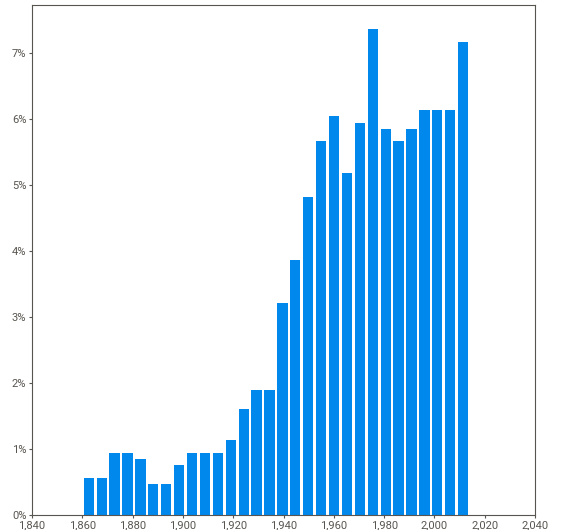
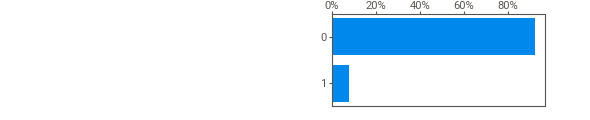
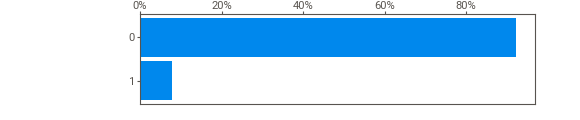
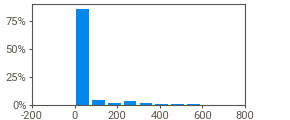
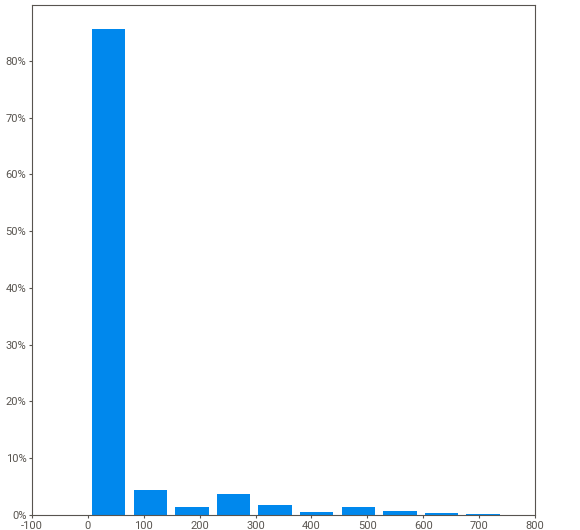
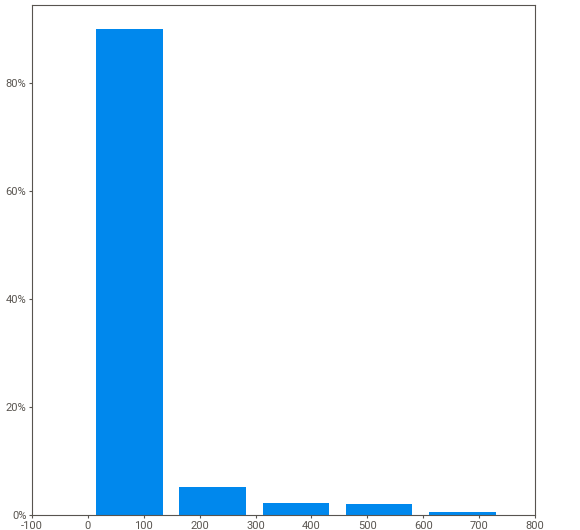
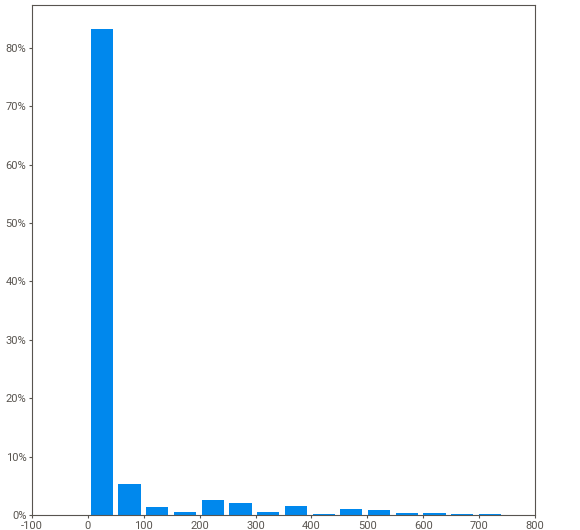
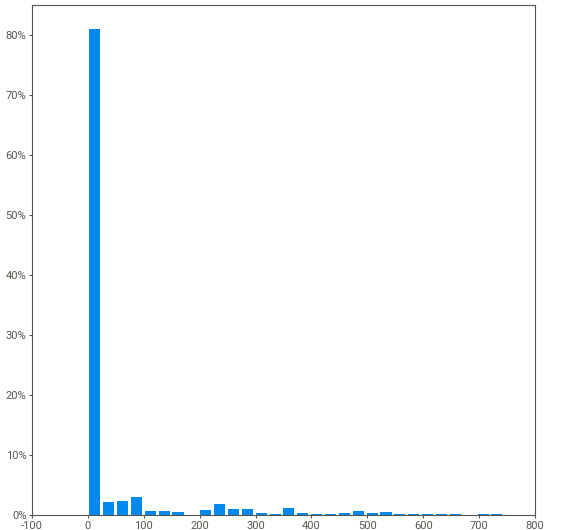
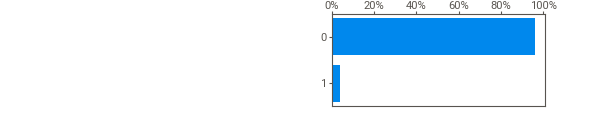
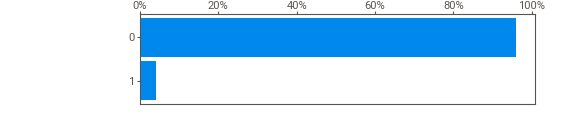
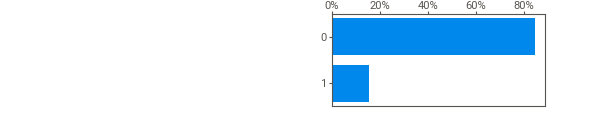
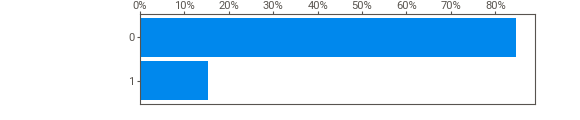
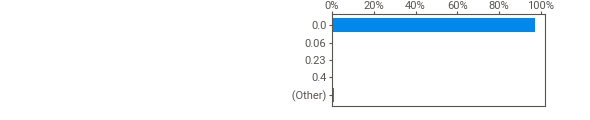
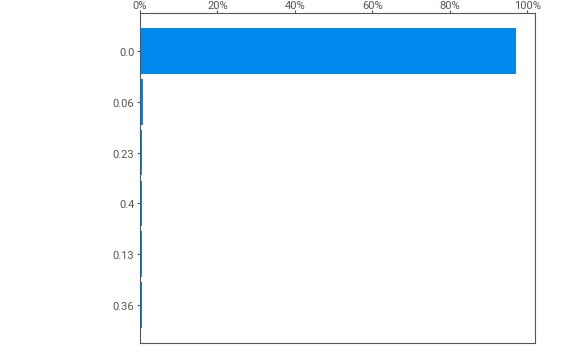
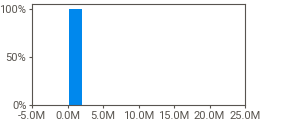
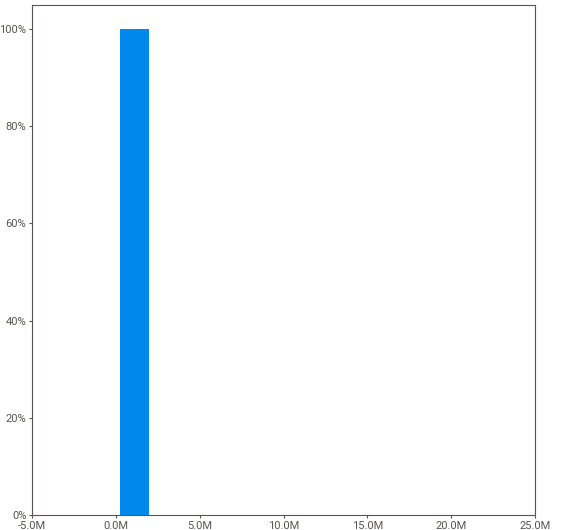
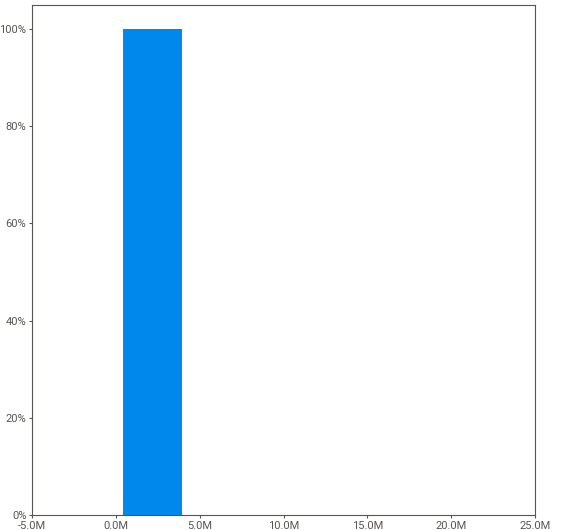
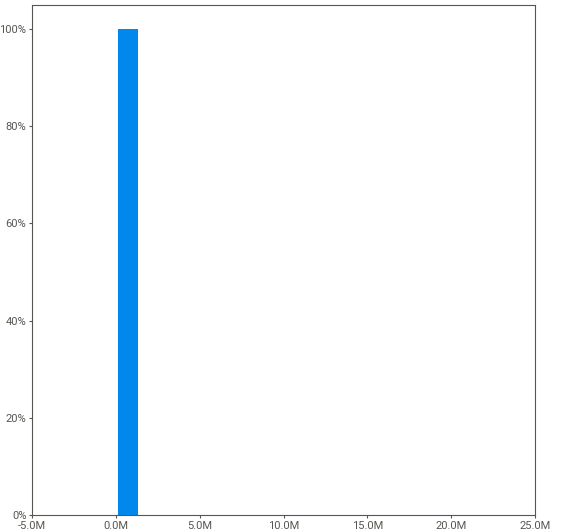
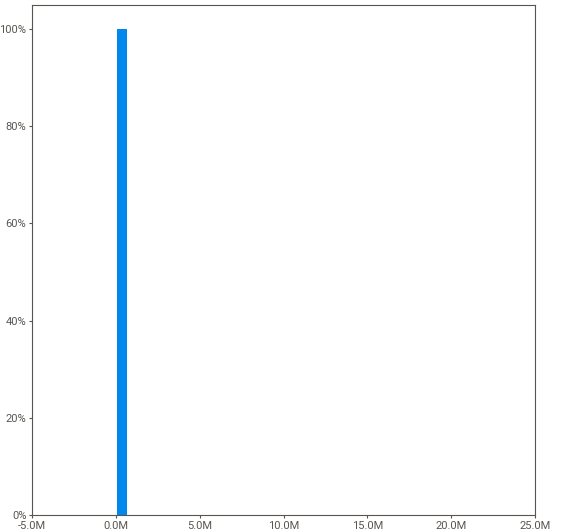
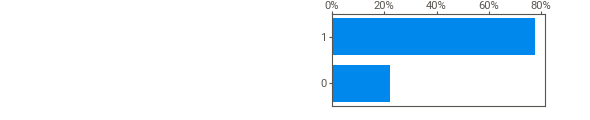
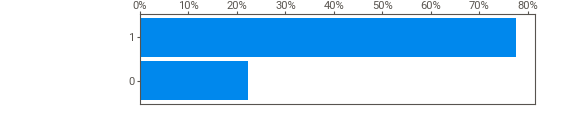
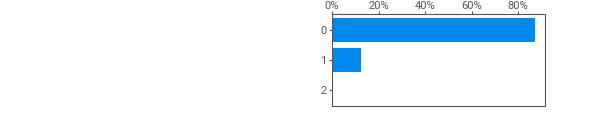
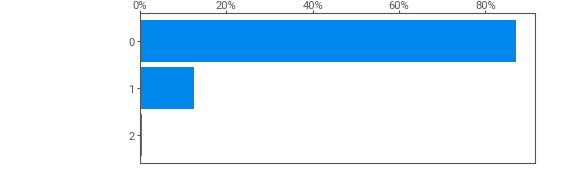
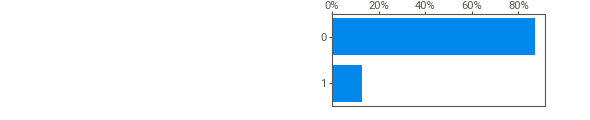
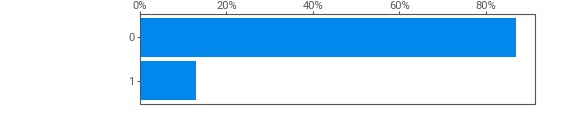
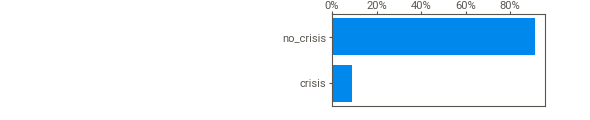
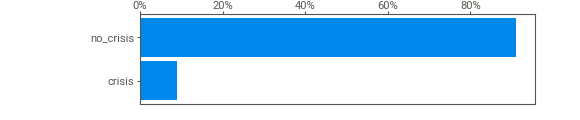
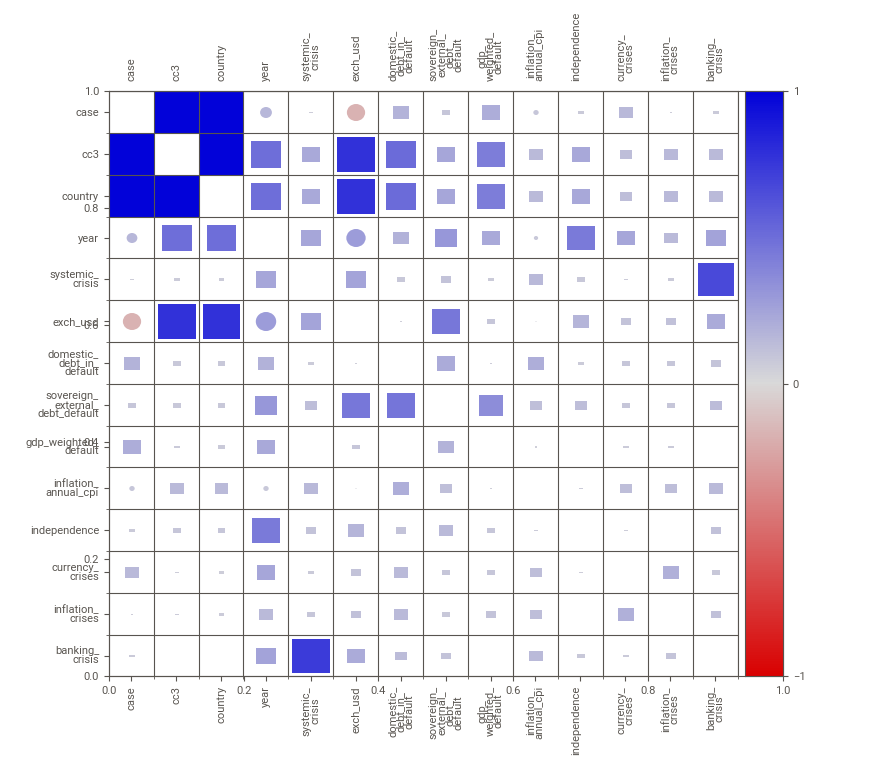
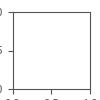

In [3]:
report = sv.analyze(df)
report.show_notebook() #use show_html() if this doesn't work for some reason

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case                             1059 non-null   int64  
 1   cc3                              1059 non-null   object 
 2   country                          1059 non-null   object 
 3   year                             1059 non-null   int64  
 4   systemic_crisis                  1059 non-null   int64  
 5   exch_usd                         1059 non-null   float64
 6   domestic_debt_in_default         1059 non-null   int64  
 7   sovereign_external_debt_default  1059 non-null   int64  
 8   gdp_weighted_default             1059 non-null   float64
 9   inflation_annual_cpi             1059 non-null   float64
 10  independence                     1059 non-null   int64  
 11  currency_crises                  1059 non-null   int64  
 12  inflation_crises    

In [5]:
df.banking_crisis

0          crisis
1       no_crisis
2       no_crisis
3       no_crisis
4       no_crisis
          ...    
1054       crisis
1055    no_crisis
1056    no_crisis
1057    no_crisis
1058    no_crisis
Name: banking_crisis, Length: 1059, dtype: object

In [ ]:
msno.matrix(df)

We have a clean dataset here i.e no missing values. We'll have to create a target variable based on the various variables that indicate whether there was a particular type of crisis or not in a particular year (note that while `systemic_crisis`,`domestic_debt_in_default`,`sovereign_external_debt_default`,`currency_crises` and `inflation_crises` are all numerical with 1 meaning a crisis occurred in the year and 0 no crisis occurred, `banking_crisis` is of type string and has `crisis` and `no_crisis` as values). We also have to bear in mind the possibility of multiple crises of several types in a single year (e.g a currency crisis and an inflation crisis in the same year).

Let's create the target variable now:

In [6]:
# Create the target variable 'crisis_class' based on the logic provided
def determine_crisis_class(row):
    # Columns to check for crisis (1 or 'crisis' means crisis)
    crisis_columns = [
        'systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default',
        'currency_crises', 'inflation_crises'
    ]
    
    # Count the number of crisis indicators that are 1 or 'crisis'
    crisis_count = sum([
        1 if row[col] == 1 else 0 for col in crisis_columns
    ]) + (1 if row['banking_crisis'] == 'crisis' else 0)
    
    # Use match-case to assign crisis class based on the crisis count
    match crisis_count:
        case count if count >= 2:
            return 2  # Multiple crises
        case 1:
            return 1  # Single crisis
        case _:
            return 0  # No crisis

# Apply the function to the dataset to create the 'crisis_class' column
df['crisis_class'] = df.apply(determine_crisis_class, axis=1)

# Show the distribution of the target variable
# Show the distribution of the target variable with both count and percentage
class_counts = df['crisis_class'].value_counts()
class_percentages = round(df['crisis_class'].value_counts(normalize=True) * 100,2)

# Combine counts and percentages into a DataFrame for better readability
class_distribution = pd.DataFrame({
    'Count': class_counts,
    'Percentage': class_percentages
})

# Display the class distribution
print(class_distribution)

              Count  Percentage
crisis_class                   
0               709       66.95
1               188       17.75
2               162       15.30


Our dataset is quite imbalanced: as could be expected, we have many more samples of years without crises (fortunately!). The proportions of single and multi-crises are relatively equivalent.

We can now safely drop all the columns that were used to create the target variable.

In [7]:
df.drop(columns=['systemic_crisis', 'domestic_debt_in_default', 'sovereign_external_debt_default',
        'currency_crises', 'inflation_crises','banking_crisis'],inplace=True)

When we analyse time series, i.e data that has a temporal component (just like here data that is ordered by year), it is frequent that we use what we call lagged variables in our analysis (e.g if we were to calculate ` inflation_annual_cpi` lagged by one year, for each observation, we would take the value of annual inflation of the year before). Why is that? Because the "present" depends on the past and we want to capture the effects of past values of a variable on its current value.

So, before we go on with our modelling, we'll do a bit of feature engineering and compute 1-year lagged variables for `gdp_weighted_default`, `inflation_annual_cpi` and `exch_usd`. Obviously, by so doing, the first row (i.e the first year of observations) of the lagged variables will have missing values so we'll drop that row.

Before we do that, we want to make sure our observations are ordered in the correct order of year and country:

In [8]:
df = df.sort_values(by=["year", "country"]).reset_index(drop=True)

In [10]:
# Define lag features for numeric columns
lag_features = ["exch_usd", "inflation_annual_cpi", "gdp_weighted_default"]

# Create lagged versions (1-year lag)
for feature in lag_features:
    df[f"{feature}_lag1"] = df.groupby("country")[feature].shift(1)

# Drop rows with missing lag values
df = df.dropna().reset_index(drop=True)

We're now ready to do the modelling.

We first divide the data in feature set and target variable: we're dropping identifiers and non-predictive variables such as `country` or `year` or country code `cc3` from the feature set.

In [11]:
target = "crisis_class"  # Multi-class target variable
features = [col for col in df.columns if col not in ["case", "cc3", "country", "year", target]]

X = df[features]
y = df[target]

Next, comes the step where we split the data in training and test sets. Because the data has a temporal component to it (and it has been ordered by year and country), we can't just do the usual `train_test_split`. Instead, we use `TimeSeriesSplit`.

Unlike `train_test_split`, which randomly shuffles data, `TimeSeriesSplit` preserves the chronological order of observations.
`TimeSeriesSplit` iteratively increases the size of the training set while keeping the test set forward-looking.
At each fold, the test set contains data that comes after the training set (no leakage from the future into the past).
The number of splits determines how many times the model is trained and validated.

Example (5 splits):

Assume we have 10 time steps:

```python
Data: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
```

A `TimeSeriesSplit(n_splits=3)` would create these folds:

|Fold|	Training Set|	Test Set|
|----|--------------|-----------|
|1	|[1, 2, 3, 4]	|[5, 6]|
|2	|[1, 2, 3, 4, 5, 6]|	[7, 8]|
|3	|[1, 2, 3, 4, 5, 6, 7, 8]|	[9, 10]|

How is it Different from `train_test_split`?

|Feature	|`TimeSeriesSplit`	|`train_test_split`|
|----|--------------|-----------|
|Data order	|Maintained	|Shuffled (by default)|
|Data leakage risk	|Lower (respects time)|	Higher (if time is ignored)|
|Use case	|Time series forecasting|	General ML tasks|
|Splits	|Multiple folds|	Single split|

In [12]:
tscv = TimeSeriesSplit(n_splits=5)

When dealing with class imbalance, we can look at metrics that are not sensitive to class imbalance (e.g F1-score, precision, recall). But we can also intervene at the dataset level by balancing out the classes either by downsampling the majority class i.e reducing the number of examples of your majority class to (roughly) equal the number of samples of the minority class or by oversampling your minority class i.e creating synthetic examples of the minority class based on existing ones (a method that does this - which we used is called [SMOTE](https://medium.com/@corymaklin/synthetic-minority-over-sampling-technique-smote-7d419696b88c#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjFkYzBmMTcyZThkNmVmMzgyZDZkM2EyMzFmNmMxOTdkZDY4Y2U1ZWYiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTU0NDAwMjI2NDg3MDk0MTU4NDkiLCJlbWFpbCI6ImJlcnJhZGEuZ2hpdGFAZ21haWwuY29tIiwiZW1haWxfdmVyaWZpZWQiOnRydWUsIm5iZiI6MTczMTY0NjQ3MiwibmFtZSI6IkdoaXRhIEJlcnJhZGEiLCJwaWN0dXJlIjoiaHR0cHM6Ly9saDMuZ29vZ2xldXNlcmNvbnRlbnQuY29tL2EvQUNnOG9jSXdDODZ6Z1ZFTkpSNU9yRDhSenJEWXBKT3ZtNU5YUDU3ejNFNkQ3YnlDMjUySDJ6SHdNQT1zOTYtYyIsImdpdmVuX25hbWUiOiJHaGl0YSIsImZhbWlseV9uYW1lIjoiQmVycmFkYSIsImlhdCI6MTczMTY0Njc3MiwiZXhwIjoxNzMxNjUwMzcyLCJqdGkiOiJmZGFkZDZhOTE5ZmVlZDFmOGYyYWUxMGQxNWU0MjMwMTI4ZDZjMDZiIn0.AKZzkGa_6h6fhv4XyI8ag8dk-QxceD4CQTbqcbu8jG6z2c-aUDojRDfHYzcRvVFkEyZhACS0daSuBsFr_XhRFr_RmZM84_kXmBYswohA1DCsEg0aLCCi6F-1Ym_WBwT66CBQarJ3QBX2rDXpLT4r1O4YW0LC3zFS7MAxTNcoaYJCeMa72WB8axup2v2BLqPr4DdByc9JWuO33lP-THXDN70YlJ9hwt7g_gIEJ-AdqhidYBlBsKHynNCsDZA5Hk64qVhZarVvWlqGSBXAvFqRT7mbEYfKhBR0AATOHj9PB2SMMQtocdbl5YfZDgE2lO61Ywi9CFluf_soYf4x0FwVsg), invoked through the `SMOTE` method from the `imblearn.over_sampling` library. You'll find the original paper that describes SMOTE [here](https://arxiv.org/abs/1106.1813)).

Both downsampling and oversampling have downsides:

-   if you have too few data points, downsampling is not a method you should use as it leaves you with even fewer data points, compromising further model training

-   On the flip side, oversampling may lead to overfitting since the new minority class data points are generated from pre-existing ones and there might not be enough diversity in the training set (though SMOTE is designed to try and circumvent this problem)
  
Another thing we did to help deal with class imbalance is adjust class weights during training. What is the idea here? By default, when training models, class weights are set equal, meaning that errors in classification made in one class or another are penalized equally. When we set class weights, e.g through setting the Catboost `auto_class_weights` parameter to `Balanced`, we're setting the weights in such a way that the errors made on the minority class are penalized more heavily. See more details on class weights [here](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/#h-what-are-class-weights).

We tune a CatBoost model (tree ensemble model) as:

- it doesn't require much pre-processing (scaling not needed!)
- it handles both categorical and numerical features out-of-the-box (`independence` is categorical)
- it remains interpretable to an extent (it provides feature importance like all tree models)
- it doesn't assume linearity
- it's less prone to overfitting than a decision tree

Let's quickly tune and fit our model. We first tune the model hyperparameters and get hyperparameters that optimize AUC for CatBoost.

In [13]:
# Define hyperparameter grid for tuning
param_grid = {
    "iterations": [500, 1000],
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "l2_leaf_reg": [1, 5, 10],
    "auto_class_weights": ["Balanced"],
    "loss_function": ["MultiClass"]
}

# Initialize CatBoost classifier
catboost = CatBoostClassifier(verbose=0, random_seed=42)
auc_scorer = make_scorer(roc_auc_score, multi_class="ovr", average="macro")

# Perform Grid Search for hyperparameter tuning on the entire dataset (using the TimeSeriesSplit)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, scoring=auc_scorer, cv=tscv, n_jobs=-1)
grid_search.fit(X, y)

# Get the best model parameters from GridSearchCV
best_params = grid_search.best_params_

# Print best hyperparameters found by GridSearchCV
print(f"Best Hyperparameters: {best_params}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 388, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Hyperparameters: {'auto_class_weights': 'Balanced', 'depth': 4, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.01, 'loss_function': 'MultiClass'}


Then we compute evaluation metrics our model using (time-aware) cross-validation (we also oversample (SMOTE) the training set for cross-validation fold to handle class imbalance better):

In [14]:
# Lists to store metrics and confusion matrices
train_results, test_results = [], []
train_cm_sum, test_cm_sum = None, None
num_folds = tscv.get_n_splits()

# Define metric functions
metric_functions = {
    'balanced_accuracy': balanced_accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average="macro"),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average="macro"),
    'f1_score': lambda y_true, y_pred: f1_score(y_true, y_pred, average="macro"),
    'auc': lambda y_true, y_proba: roc_auc_score(y_true, y_proba, multi_class="ovr"),
    'auc_pr': lambda y_true, y_proba: average_precision_score(y_true, y_proba, average="macro")
}

# Cross-validation loop with consistent hyperparameters
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"Processing fold {fold}/{num_folds}...")

    # Split data into train and test for this fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Apply SMOTE if needed
    if y_train.value_counts().min() > 5:
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    else:
        X_train_res, y_train_res = X_train, y_train

    # Train the model with the best found hyperparameters
    best_model = CatBoostClassifier(**best_params, verbose=0)
    best_model.fit(X_train_res, y_train_res)

    # Predict on train & test sets
    y_pred_train = best_model.predict(X_train_res)
    y_pred_test = best_model.predict(X_test)
    y_proba_train = best_model.predict_proba(X_train_res)
    y_proba_test = best_model.predict_proba(X_test)

    # Compute per-fold metrics
    train_metrics = {name: metric(y_train_res, y_pred_train if "auc" not in name else y_proba_train) for name, metric in metric_functions.items()}
    test_metrics = {name: metric(y_test, y_pred_test if "auc" not in name else y_proba_test) for name, metric in metric_functions.items()}

    train_results.append(train_metrics)
    test_results.append(test_metrics)

    # Compute confusion matrices
    labels = np.sort(y.unique())
    cm_train = confusion_matrix(y_train_res, y_pred_train, labels=labels)
    cm_test = confusion_matrix(y_test, y_pred_test, labels=labels)

    # Aggregate confusion matrices
    train_cm_sum = cm_train if train_cm_sum is None else train_cm_sum + cm_train
    test_cm_sum = cm_test if test_cm_sum is None else test_cm_sum + cm_test

# Convert metrics to DataFrame and compute averages
train_df = pd.DataFrame(train_results)
test_df = pd.DataFrame(test_results)
metrics_df = pd.DataFrame({"Metric": train_df.columns, "Train": train_df.mean().round(2), "Test": test_df.mean().round(2)})


# Print metrics in a markdown table
print("### Model Performance Metrics")
writer = MarkdownTableWriter()
writer.table_name = "Model Performance"
writer.headers = ["Metric", "Train", "Test"]
writer.value_matrix = metrics_df.values.tolist()  
writer

Processing fold 1/5...
Processing fold 2/5...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...
### Model Performance Metrics


# Model Performance
|     Metric      |Train|Test|
|-----------------|----:|---:|
|balanced_accuracy| 0.86|0.50|
|precision        | 0.82|0.50|
|recall           | 0.86|0.50|
|f1_score         | 0.83|0.44|
|auc              | 0.96|0.60|
|auc_pr           | 0.93|0.52|

We draw the (averaged) confusion matrices over all cross validation folds:

In [15]:
# Compute mean confusion matrices
train_cm_avg = np.round(train_cm_sum / num_folds).astype(int)
test_cm_avg = np.round(test_cm_sum / num_folds).astype(int)

# Convert confusion matrices to DataFrame
def get_cm_df(cm, dataset, labels):
    return pd.DataFrame([
        (actual, predicted, cm[i, j]) for i, actual in enumerate(labels) for j, predicted in enumerate(labels)
    ], columns=["Actual", "Predicted", "Count"]).assign(Dataset=dataset)

train_cm_df = get_cm_df(train_cm_avg, "Train", labels)
test_cm_df = get_cm_df(test_cm_avg, "Test", labels)

# Function to plot confusion matrix
def plot_confusion_matrix(df, dataset_name):
    return (
        ggplot(df, aes("Predicted", "Actual", fill="Count"))
        + geom_tile(color="black")
        + geom_text(aes(label="Count"), size=12)
        + scale_fill_gradient(low="white", high="#FF7F50")
        + scale_x_continuous(breaks=labels)
        + scale_y_continuous(breaks=labels)
        + ggtitle(f"{dataset_name} Confusion Matrix \n(Averaged over {num_folds} folds)")
        + theme(axis_text_x=element_text(angle=0, hjust=1))
        + ggsize(450, 450)
    )

# Plot confusion matrices
p_train = plot_confusion_matrix(train_cm_df, "Train")
p_test = plot_confusion_matrix(test_cm_df, "Test")

gggrid([p_train, p_test], ncol=2, widths=[1, 1])

The large difference in performance between the training and test sets across nearly all metrics indicates overfitting. The model performs very well on the training set, but it struggles to generalize to the test set. Even with oversampling (SMOTE) and the use of class weights, the model is likely struggling to properly identify and classify the minority classes in the test set. The precision and recall metrics being low for the test set suggest that the model may be biased towards the majority class (crisis class = 0). SMOTE helps balance the class distribution by creating synthetic samples, but it's not a perfect solution, especially when class imbalance is significant.

The recall and F1 score on the test set are particularly low. This is likely a sign that the model isn't identifying the positive classes (1 and 2) well at all.

The confusion mtrix for the test set shows that the models struggles particularly with class 2:

- out of a total of (10+12+9) actual instances of class 2, it only correctly predicted 9 i.e 29% compared to 15 correctly predicted instances of classe 1 out of the actual (15+15+4) instances of class 1 i.e 44.1%.

In [16]:
# -------------------------------
# 🔥 FEATURE IMPORTANCE PLOT
# -------------------------------
importance = pd.DataFrame({
    'feature': features,
    'importance': best_model.feature_importances_
})

importance = importance.sort_values(by='importance', ascending=True)

importance_plot = (
    ggplot(importance) 
    + aes(x="importance", y="feature") 
    + geom_bar(stat='identity') 
    + ggtitle("Feature Importance (CatBoost)")
    + theme_minimal()
)

importance_plot.show()

The importance shows the most important variables to be:
- annual consumer price index
- the exchange rate of the country vis-a-vis the USD (both current and lagged variable)
- the variable indicating whether the country is independent or not

*Conclusion:*

How could we improve our modeling further?

- We could try different values of hyperparameters and adjust them more finely
- We could try other oversampling strategies (beyond SMOTE e.g ADASYN or SMOTENC -see [here](https://imbalanced-learn.org/stable/over_sampling.html)) or even a combination of oversampling and undersampling
- we could try other ensemble methods e.g XGBoost, Random Forest or even better Balanced Random Forest (which is a variant of Random Forest specifically designed to handle imbalanced data, the idea being that it undersamples the majority class so that each tree gets a balanced dataset between the majority and minority classes - see [here](https://medium.com/@fadleemt/balanced-random-forest-d5dc9c896bb4))
- we could also obviously tune classification thresholds!

## Part 2: Motivations for Unsupervised Learning

Sometimes, we don't have a target variable to predict. We just want to understand the structure of our data. This is where **unsupervised learning** comes in.

Unsupervised learning is used in many different contexts and comes in four main families:

### Types of Unsupervised Learning

<div>

### Clustering

-   Consists in dividing data points into clusters, i.e groups of points that are similar between themselves and are dissimilar to data points belonging to other cluster
-   Examples:
    -   segmenting patients with a particular condition (e.g cancer) into groups depending on their response to particular treatment drugs (aim: treatment personalisation)
    -   customer segmentation according to common traits and/purchasing behaviour (aim: guiding marketing and business strategies)
    -   Image segmentation (e.g in radiology or pathology)
    -   Object recognition (in computer vision)
    -   Natural language processing (NLP): Google News uses clustering to categorize articles based on the same story from various news outlets; for example, the results of the football transfer window would all be categorized under football.

### Association rule mining

-   Series of algorithms that try to find rules to discover the probability of the co-occurrence of items in a collection (e.g Apriori, Eclat, FPGrowth)
-   E.g:
    -   Given a collection of supermarket purchase records/transactions, can we tell how likely a customer is to buy milk if he/she has bought bread? (Market Basket analysis)
    -   Can we learn how likely a series of medical diagnoses are, given the symptoms to which they are associated?
    -   Recommendation engines (e.g Netflix or Youtube video recommendations, Amazon recommendations)

### Dimensionality reduction

-   Techniques that reduce the number of features, or dimensions, in a dataset (prior to applying a supervised/unsupervised learning algorithm)

    Example:

    -   Principal component analysis (PCA - the topic of this week)
    -   or Singular value decomposition (SVD)
    -   UMAP

### Anomaly detection

-   Techniques that discover unusual data points in a dataset i.e with patterns that deviate from normal dataset patterns

-   E.g:

    -   Fraud detection (credit card fraud, insurance fraud, detection of money laundering)
    -   Rare events detection e.g detection of earthquakes, detection of epileptic seizures
    -   Cyberattack detection
    -   Also useful in predicting whether a patient has or doesn't have a disease
    -   Detecting faulty equipment

</div>

Let's now discover our first family of unsupervised learning techniques: dimensionality reduction.

## Part 3: Dimensionality reduction

### 3.1 Let's meet our new dataset

The dataset is an adaptation for this [Kaggle dataset](https://www.kaggle.com/datasets/parisrohan/credit-score-classification) about credit score classification.

The scenario is as follows:

"You work as a data scientist at a global finance company. Thoughout the years, the company has been collecting basic bank details and gathered a lot of credit-related information about their customers. The management of the company wants to build an intelligent system to divide people into credit score brackets in order to reduce manual efforts.

The task is to build a machine learning model that can predict the credit score given person's credit-related details."

In [17]:
data_url = "https://assets.datacamp.com/production/repositories/6081/datasets/e02471e553bc28edddc1fe862666d36e04daed80/credit_score.csv"

df_credit= pd.read_csv(data_url)

Let's have a quick overview of the data:

In [18]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18965 entries, 0 to 18964
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   month                     18965 non-null  object 
 1   age                       18965 non-null  int64  
 2   occupation                18965 non-null  object 
 3   annual_income             18965 non-null  float64
 4   monthly_inhand_salary     18965 non-null  float64
 5   num_bank_accounts         18965 non-null  int64  
 6   num_credit_card           18965 non-null  int64  
 7   interest_rate             18965 non-null  int64  
 8   num_of_loan               18965 non-null  int64  
 9   delay_from_due_date       18965 non-null  int64  
 10  num_of_delayed_payment    18965 non-null  int64  
 11  changed_credit_limit      18965 non-null  float64
 12  num_credit_inquiries      18965 non-null  int64  
 13  credit_mix                18965 non-null  object 
 14  outsta

No missing values here. Quite a large dataframe (18965 rows and 23 columns).

Do you think we can visualise this many features?

Here are a few visualisations we can make:

In [19]:
# Plot of annual income distribution for different credit score levels
ggplot(df_credit, aes(x='annual_income', color='credit_score', fill='credit_score')) + \
    geom_density(alpha=0.3) +  \
    scale_x_continuous(limits=(0, 200000)) +  \
    labs(
        x="Annual income (USD)",  # x-axis label
        y="Density",  # y-axis label
        color="Credit score",  # legend title
        fill="Credit score"  # fill legend title
    )

Annual income is a useful predictor variable. From the plot, people with a low annual income have poorer credit scores.

In [20]:
#Age Density Plot
ggplot(df_credit, aes(x = 'age', color = 'credit_score',fill='credit_score')) + \
     geom_density(alpha=0.3) +  \
    scale_x_continuous(limits=(15, 60)) +  \
    labs(
        x="Age",  # x-axis label
        y="Density",  # y-axis label
        color="Credit score",  # legend title
        fill="Credit score"  # fill legend title
    )

It also seems that older people have better credit scores, making the `age` feature a great predictor.

We could go on...

### 3.2 Principal component analysis (PCA)

Principal Component Analysis is a **principled way** to reduce features prior to applying a supervised or unsupervised learning technique.

The goal is to reduce computational cost and make it possible to visualise the results:

-   Suppose that you wish to visualize $n$ observations with measurements on a set of $p$ features, $X_1$, $X_2$,..., $X_p$. You could conceivably visualise them with a series of two-dimensional scatterplots, each representing all the $n$ for two of the $p$ features. But, you'd need $(^P_2)=\frac{p(p-1)}{2}$ scatterplots!

    In our previous credit score example, this would mean 253(!) plots!

-   on top of this, it's highly likely that none of the 2D-plots will be informative enough since they each contain just a small fraction of the total information present in the data set

    Enter PCA (Principal Component Analysis).

    The aim of PCA is to find a low-dimensional representation of a data set that contains as much as possible of the variance of the data.

    Each of the dimensions found by PCA is a linear combination of the $p$ features (the total of dimensions of dimensions found by PCA is equal to the number of dimensions in the data i.e $p$ so that the total variance preserved by all dimensions is 100% - to reduce dimensions you then set a threshold of variance kept, which gives you the number of PCA dimensions to keep).

    The first principal component of a set of features $X_1$, $X_2$,..., $X_p$ is the normalized linear combination of the features $Z_1 = φ_{11}X1 + φ_{21}X_2 + ··· + φ_{p1}X_p$ that has the largest variance ( with normalized meaning $\sum_{j=1}^p \phi_{j1}^2$ ). The elements $φ_{11}$,..., $φ_{p1}$ are the loadings of the first principal loading component.

    The second principal component is chosen as the normalized linear combination of features $X_1$,..., $X_p$ that maximizes the (remaining) variance out of all linear combinations that are uncorrelated with $Z_1$.

    And so on and so forth until all principal components are computed.

    In practice, just as you saw on Monday...


In [21]:
# we split our data into features and target variable
X_credit = df_credit.drop(columns='credit_score')  # All predictors
y_credit = df_credit['credit_score']  # Target variable

`X_credit` is a DataFrame containing all the features (independent variables) except for the `credit_score`.
`y_credit` is the target variable (the `credit_score`), which we want to try and predict later.


We want to try and reduce the number of features in our set of features but before we do that, we can only keep numerical features, since PCA only applies on numerical features (if we wanted to apply PCA on all features including non-numerical ones, we would have to convert the non-numerical features to numerical ones first before applying PCA but we won't do that here). Here, we simply select the set of features of type `float64` or `int64` before proceeding.

In [22]:
# Since PCA only applies on numerical variables, we select numeric columns for preprocessing
numeric_cols = X_credit.select_dtypes(include=['float64', 'int64']).columns

PCA works by finding directions of maximum variance so features with very high variance might dominate the calculation. We could either check the variance of the numeric features in our data or alternatively their skewness (a Gaussian distribution has zero skew, while skewed data often has high variance due to extreme values).

In what follows, we check for variables with a highly skewed distribution (right-skewed if the skew is > 1 and left-skew if < 1) then we apply a Yeo-Johnson transformation to make the distribution of these variables closer to a Gaussian (we go for Yeo-Johnson because it applies to variables that have a mix of negative and positive values unlike the logarithmic transformation that only applies to positive values).

In [23]:
# Identify highly skewed features
skew_values = X_credit[numeric_cols].skew().sort_values(ascending=False)
skewed_cols = skew_values[abs(skew_values) > 1].index.tolist()
print("The columns with high skew are :", "\n".join(skewed_cols))
# Apply Yeo-Johnson transformation (works for negative values)
pt = PowerTransformer(method='yeo-johnson')
X_credit[skewed_cols] = pt.fit_transform(X_credit[skewed_cols])

The columns with high skew are : num_of_loan
num_of_delayed_payment
annual_income
num_bank_accounts
num_credit_inquiries
interest_rate
num_credit_card
total_emi_per_month
amount_invested_monthly
monthly_inhand_salary
outstanding_debt
monthly_balance


Now we're ready to define our pre-processing i.e PCA pipeline.

We use a `Pipeline` to chain together multiple preprocessing steps into a single workflow. This ensures all the steps (transforming the data) happen in a specific sequence.

Within the pipeline, we apply operations column per column using `ColumnTransformer` (not all columns will be processed in an identical way!):

- we apply `VarianceThreshold` to remove columns that have zero variance (i.e., columns where all values are the same). Such columns don't contribute useful information to the model.
- we apply `StandardScaler` to standardize the (numeric) columns (this results in them having a mean of 0 and standard deviation of 1). This step ensures that each feature contributes equally to the PCA, since PCA is sensitive to the scale of the features

The final step in the pipeline is PCA (Principal Component Analysis). Here, we are reducing the dataset to 2 principal components (`n_components=2`), which means we're transforming the data from 22 features to just 2 key features (principal components) that capture the maximum variance in the data. We do this to make the data easier to visualize.

We then:

- fit the pipeline to the data (`pipeline.fit(X_credit)` line), meaning that we apply the preprocessing steps (variance threshold and standardization) to the dataset. For PCA, this step also calculates the principal components based on the dataset.

- After fitting, we use `transform` (`pipeline.transform(X_credit)` line) to actually reduce the dimensionality of the data. This means we're taking the original high-dimensional data and transforming it into 2 principal components that summarize the most important features.

After that, we simply convert the PCA results (the transformed data) into a `DataFrame` with two columns: PC1 and PC2. These represent the first and second principal components (`pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])` line) and print the content of the DataFrame to check the results.

In [24]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            # we remove zero variance features
            ('zv', VarianceThreshold(), numeric_cols),
            # we normalize numeric columns
            ('scaler', StandardScaler(), numeric_cols),
        ]
    )),
    ('pca', PCA(n_components=2))  # we keep 2 principal components for PCA (for visualisation purposes)
])

# Fit the pipeline
pipeline.fit(X_credit)

# Transform the data using the fitted pipeline
pca_results = pipeline.transform(X_credit)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])

# Display the first few rows
print(pca_df.head())

          PC1        PC2
0  122.967037  -5.805426
1  176.026207   3.618021
2   36.008175 -13.096926
3  -77.059170  -4.985719
4  -63.129047  13.792094


In [25]:
# Ensure PC1 and PC2 are numeric (this step is crucial to avoid string issues)
pca_df['PC1'] = pd.to_numeric(pca_df['PC1'], errors='coerce')
pca_df['PC2'] = pd.to_numeric(pca_df['PC2'], errors='coerce')

# Drop any rows with NaN values (after conversion, there might be some)
pca_df = pca_df.dropna(subset=['PC1', 'PC2'])

# Define the tick positions and labels
pc1_ticks = np.linspace(pca_df['PC1'].min(), pca_df['PC1'].max(), 6)  # Create 6 ticks
pc2_ticks = np.linspace(pca_df['PC2'].min(), pca_df['PC2'].max(), 6)

pc1_labels = [f'{x:,.0f}' for x in pc1_ticks]
pc2_labels = [f'{x:,.0f}' for x in pc2_ticks]


# Create the plot
p = ggplot(pca_df, aes(x='PC1', y='PC2')) + \
    geom_point(color='#00A693') + \
    labs(
        title='Principal Components', 
        subtitle='2-dimensional representation of our 20+ numeric predictors', 
        x='PC1', 
        y='PC2'
    ) + \
    scale_x_continuous(breaks=pc1_ticks, labels=pc1_labels) +  \
    scale_y_continuous(breaks=pc2_ticks, labels=pc2_labels) + \
    theme_minimal() + \
    theme(
        axis_text_x=element_text(angle=0, hjust='right'),  # Rotate x-axis labels for better readability
        axis_text_y=element_text(angle=0, hjust='right')   # Rotate y-axis labels for consistency
    )

p = p + ggsize(2000,2500)
# Show the plot
p.show()

Let's backtrack a bit and re-do my PCA this time without limiting the number of principal components.

My initial pipeline is the same as before:

In [26]:
# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[
            # Remove zero variance features
            ('zv', VarianceThreshold(), numeric_cols),
            # Normalize numeric columns
            ('scaler', StandardScaler(), numeric_cols),
        ]
    )),
    ('pca', PCA())  # Fit PCA without limiting the number of components
])

# Fit the pipeline
pipeline.fit(X_credit)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('zv', VarianceThreshold(),
                                                  Index(['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',...
                                                  Index(['age', 'annual_income', 'monthly_inhand_salary', 'num_bank_accounts',
       'num_credit_card', 'interest_rate', 'num_of_loan',
       'delay_from_due_date', 'num_of_delayed_payment', 'changed_credit_limit',
       'num_credit_inquiries', 'outstanding_debt', 'credit_utilization_ratio',
       'total_emi_per_month', 'amount_invested_monthly', 'monthly_balance',
       'credit_history_months'],
      dtype='object'))])),
                ('pca', PCA())])

Now, I extract the PCA results (i.e the explained variance per principal component and the cumulative variance) and plot the explained variance per principla component:

In [27]:
# Extract PCA results
pca = pipeline.named_steps['pca']
explained_variance = pca.explained_variance_ratio_

In [28]:
# Create DataFrame for plotting
eigenvalues = pd.DataFrame({
    'PC': np.arange(1, len(explained_variance) + 1),
    'variance_explained': explained_variance,
    'cumulative': np.cumsum(explained_variance)
})

# Explained variance and cumulative variance
print("Explained Variance Ratios:\n", explained_variance)
print("Cumulative Variance:\n", eigenvalues['cumulative'])

# Calculate the offset for the labels to be above the bars
eigenvalues['label_offset'] = eigenvalues['variance_explained'] - 0.02  # Add an offset

# Variance Explained per PC with rotated labels above bars
p1 = ggplot(eigenvalues, aes(x='PC', y='variance_explained')) + \
    geom_bar(stat='identity', fill='#00A693', width=0.7) + \
    geom_text(aes(label=round(eigenvalues['variance_explained'], 2)), 
              angle=0,  # Rotate the labels 90 degrees
              vjust=4.5,  # Position the labels above the bars
              hjust=1.5) +  \
    labs(
        title="Variance Explained by Each Principal Component",
        x="Principal Component",
        y="Variance Explained"
    ) + \
    theme_minimal()

p1 = p1+ggsize(1200,1200)
# Show the plot
p1.show()

Explained Variance Ratios:
 [9.67789593e-01 1.56900873e-02 8.78007147e-03 3.68075031e-03
 2.38409365e-03 3.99675182e-04 1.93061062e-04 1.75035309e-04
 1.57294328e-04 1.42737957e-04 1.32291119e-04 1.19529728e-04
 1.08984182e-04 1.00032927e-04 7.28991928e-05 6.16203213e-05
 1.22434390e-05 1.84250168e-16 2.65837254e-17 9.84737485e-18
 3.37343607e-18 9.92359496e-19 6.96568812e-19 4.20408988e-19
 3.12871460e-19 1.27415106e-19 3.73908920e-20 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Cumulative Variance:
 0     0.967790
1     0.983480
2     0.992260
3     0.995941
4     0.998325
5     0.998724
6     0.998917
7     0.999092
8     0.999250
9     0.999392
10    0.999525
11    0.999644
12    0.999753
13    0.999853
14    0.999926
15    0.999988
16    1.000000
17    1.000000
18    1.000000
19    1.000000
20    1.000000
21    1.000000
22    1.000000
23    1.000000
24    1.000000
25    1.000000
26    1.000000
27    1.000000
28    1.00

In [29]:
#plot of cumulative variance
p2 = ggplot(eigenvalues, aes(x='PC', y='cumulative')) + \
    geom_line(color='#00A693', size=1) + \
    geom_bar(stat='identity', fill='#ACE1AF', width=0.7) + \
    geom_text(aes(label=round(eigenvalues['cumulative'], 2)), vjust=-0.2) + \
    labs(
        title="Cumulative Variance Explained",
        x="Principal Component",
        y="Cumulative Variance"
    ) + \
    theme_minimal()

p2 = p2+ggsize(1200,1200)
p2.show()

My first principal component already explains about 97% of the variance of my data! It completely dominates the other principal components (the YeoJohnson might not have been enough and we might need to drop an "overpowering" variable). With three principal components, I keep 99% of the variance: I wouldn't lose much information if I were to only keep these three.

How do I make the difference between two or three?

Generally it comes down to the difference in the model, I build after this. In this case, I am interested in predicting credit score.

Let me build a Balanced Random Forest model to predict such a score.


Let's split our data into training and test set

In [30]:
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit[numeric_cols],y_credit,stratify=y_credit,random_state=123)

print("We have", len(X_train_credit), "training points.")
print("And", len(X_test_credit), "test points.")

We have 14223 training points.
And 4742 test points.


Let's write a pipeline that does standardization, PCA (keeping principal components such that at least 80% of the variance of the data is preserved) and applies a Balanced Random Forest classifier.

In [31]:
# Splitting the data
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit[numeric_cols], y_credit, stratify=y_credit, random_state=123)

# Define the pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Standardize the data
    ('pca', PCA(n_components=0.80)),  # Keep at least 80% of the variance
    ('classifier', BalancedRandomForestClassifier(random_state=123))
])

# Fit the pipeline
pipeline.fit(X_train_credit, y_train_credit)

# Predict and evaluate
y_pred_credit = pipeline.predict(X_test_credit)
print("Classification Report:")
print(classification_report(y_test_credit, y_pred_credit))

y_pred_train_credit = pipeline.predict(X_train_credit)
print("Classification Report:")
print(classification_report(y_train_credit, y_pred_train_credit))

n_components = pipeline.named_steps['pca'].n_components_
print(f"Number of principal components kept: {n_components}")

Classification Report:
              precision    recall  f1-score   support

        Good       0.51      0.76      0.61      1213
        Poor       0.68      0.62      0.65      1536
    Standard       0.60      0.47      0.53      1993

    accuracy                           0.59      4742
   macro avg       0.60      0.61      0.59      4742
weighted avg       0.60      0.59      0.59      4742

Classification Report:
              precision    recall  f1-score   support

        Good       0.99      1.00      1.00      3639
        Poor       0.98      1.00      0.99      4605
    Standard       1.00      0.98      0.99      5979

    accuracy                           0.99     14223
   macro avg       0.99      0.99      0.99     14223
weighted avg       0.99      0.99      0.99     14223

Number of principal components kept: 10


The classification report shows  the model performs excellently on the training data with very high precision, recall, and F1-scores; however since there is drastic drop in performance in the test set and the performance on the training set is close to perfect, this is likely a sign of overfitting. The recall for "Standard" is particularly poor on the test set as is the F1-score: the model fails to generalize and performs no better than random for this class. For the other two classes, the drop is also rather sharp and the performance rather middling. the performance is best for "Poor": the model is best at capturing "Poor" credit scores (i.e it is more risk averse). 


If you want additional explanations on PCA, check out this [Youtube video](https://www.youtube.com/watch?v=FgakZw6K1QQ) or this [link](https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186#:~:text=Principal%20component%20analysis%2C%20or%20PCA,more%20easily%20visualized%20and%20analyzed.) or [this link](https://towardsdatascience.com/dimensionality-reduction-made-simple-pca-theory-and-scikit-learn-implementation-9d07a388df9e/).

For even more details on PCA, have a look at chapter 12 of Gareth, James, Witten Daniela, Hastie Trevor, Tibshirani Robert and Taylor Jonathan. *An introduction to statistical learning: with applications in Python*. Springer, 2023 (it's available online [here](https://hastie.su.domains/ISLP/ISLP_website.pdf.download.html). You can also have a look at Shlens, Jonathon. "A tutorial on principal component analysis." arXiv preprint arXiv:1404.1100 (2014). [https://arxiv.org/abs/1404.1100](https://arxiv.org/abs/1404.1100)


### What are the shortcomings of PCA?

-   It needs variables to be normalized before being applied (otherwise some might have an outsize effect on the selection!). And similarly, it is sensitive to outliers (it is recommended to remove outliers before applying PCA - which you might not want to do depending on your application!).

-   It assumes linear relationships between features. The algorithm is not well suited for capturing non-linear relationships.

-   It assumes a correlation between features. If the features are not correlated, PCA will be unable to determine principal components.

-   It assumes no missing values in the data so missing values need to be handled prior to applying it.

-   Rather obvious: it only applies to numerical values!

### 3.3 UMAP

The fact that we had to select so many principal components indicates that the geometry of our data is more complex than can be represented by a linear dimensionality reduction technique.

That's where a technique like UMAP (**Uniform Manifold Approximation and Projection**) comes in.

Let's have a look at [this video](https://www.youtube.com/watch?v=eN0wFzBA4Sc) to understand how UMAP works.

Let's apply it to our data.

The pipeline is quite similar to the previous PCA/Balanced Random Forest pipeline.

In [32]:
label_encoder = LabelEncoder()
y_credit_encoded = label_encoder.fit_transform(y_credit)

# Splitting the data
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit[numeric_cols], y_credit_encoded, stratify=y_credit_encoded, random_state=123)

# Define the preprocessor with both scaling for numeric and encoding for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ])

# Define the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Apply preprocessing steps (scaling + encoding)
    ('umap', umap.UMAP(n_components=2, random_state=123)),  # Reduce to 2 components
    ('classifier', BalancedRandomForestClassifier(random_state=123))
])

# Fit the pipeline
pipeline.fit(X_train_credit, y_train_credit)

# Predict and evaluate
y_pred_credit = pipeline.predict(X_test_credit)
print("Classification Report (Test Set):")
print(classification_report(y_test_credit, y_pred_credit))

y_pred_train_credit = pipeline.predict(X_train_credit)
print("Classification Report (Training Set):")
print(classification_report(y_train_credit, y_pred_train_credit))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.59      0.46      0.51      1213
           1       0.63      0.62      0.62      1536
           2       0.55      0.63      0.59      1993

    accuracy                           0.58      4742
   macro avg       0.59      0.57      0.57      4742
weighted avg       0.58      0.58      0.58      4742

Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3639
           1       1.00      1.00      1.00      4605
           2       1.00      1.00      1.00      5979

    accuracy                           1.00     14223
   macro avg       1.00      1.00      1.00     14223
weighted avg       1.00      1.00      1.00     14223



/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Again, clear signs of overfitting here (even better performance on the training set!). The performance for class "Standard" is improved. The performance for class "Poor" is similar. The performance for class "Good" drops.

UMAP keeps 2 components where PCA kept 10 components!


### **Advantages of UMAP**

1.  UMAP is capable of preserving the global structure of the data, including topological structure and distances between points, making it a good choice for visualization and exploration.

2.  UMAP is computationally efficient and scalable, making it suitable for large datasets.

3.  UMAP can handle high-dimensional data, unlike some other dimensionality reduction methods that are limited to (rather) low-dimensional data.

### **Disadvantages of UMAP**

1.  UMAP is a relatively new method and has not been as thoroughly tested and validated as some other dimensionality reduction methods.

2.  UMAP may not perform well on data with complex non-linear structure or on data with non-uniform density.

    See [here](https://umap-learn.readthedocs.io/en/latest/faq.html) for further information/advice on UMAP.
